## Numpy multivariate normal

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
mean_i = [0, 0]
cov_i = [[0, 20], [20, 50]]  # diagonal covariance

mean_j = [-20, -20]
cov_j = [[40, 0], [0, 40]]

mean_k = [40, 10]
cov_k = [[0, -20], [-20, 50]]

/home/labpc4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.
/home/labpc4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  This is separate from the ipykernel package so we can avoid doing imports until


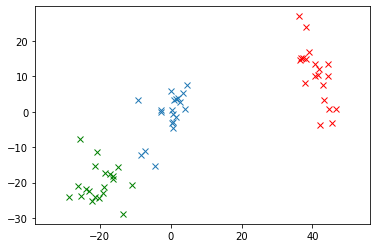

In [40]:
x_i, y_i = np.random.multivariate_normal(mean_i, cov_i, 20).T
x_j, y_j = np.random.multivariate_normal(mean_j, cov_j, 20).T
x_k, y_k = np.random.multivariate_normal(mean_k, cov_k, 20).T
plt.plot(x_i, y_i, 'x')
plt.plot(x_j, y_j, 'x', color='g')
plt.plot(x_k, y_k, 'x', color='r')
plt.axis('equal')
plt.show();

/home/labpc4/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


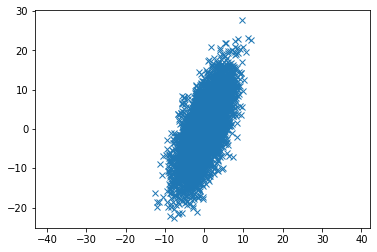

---

## EM algorithm (Scipy)

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from utils import *

In [103]:
mean_1, cov_1 = [0,0], [[20, 0], [0, 50]]
mean_2, cov_2 = [-20, -20], [[40, 0], [0, 40]]
mean_3, cov_3 = [40, 10], [[30, 0], [0, 20]]

In [17]:
model1 = multivariate_normal(mean=mean_1, cov=cov_1)
model2 = multivariate_normal(mean=mean_2, cov=cov_2)
model3 = multivariate_normal(mean=mean_3, cov=cov_3)

In [116]:
X1, Y1 = model1.rvs(size=40).T
X2, Y2 = model2.rvs(size=40).T
X3, Y3 = model3.rvs(size=40).T

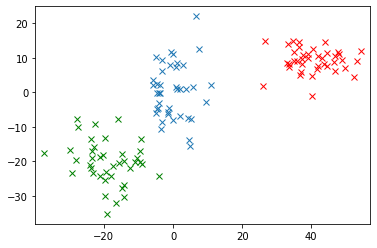

In [117]:
plt.plot(X1, Y1, 'x')
plt.plot(X2, Y2, 'x', color='g')
plt.plot(X3, Y3, 'x', color='r')
plt.axis('equal')
plt.show();

ell_radius_x:  1.0
ell_radius_y:  1.0
scale_x:  18.973665961010276
scale_y:  18.973665961010276
mean_x:  -20
mean_y:  -20


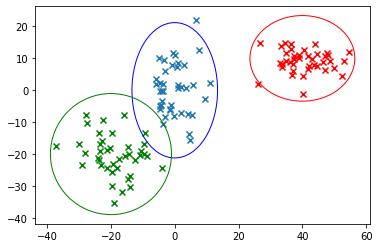

In [118]:
fig, axs = plt.subplots()
draw_ellipse(np.array(mean_1), np.array(cov_1), axs, edgecolor='blue')
draw_ellipse(np.array(mean_2), np.array(cov_2), axs, ifprint=True, edgecolor='green')
draw_ellipse(np.array(mean_3), np.array(cov_3), axs, edgecolor='red')
axs.scatter(X1, Y1, marker='x')
axs.scatter(X2, Y2, marker='x', color='g')
axs.scatter(X3, Y3, marker='x', color='r')
axs.axis('equal')
plt.show()

In [599]:
num_categories = 3
num_m = 15

In [600]:
ind_1 = np.random.choice(40, num_m)
ind_2 = np.random.choice(40, num_m)
ind_3 = np.random.choice(40, num_m)

In [601]:
x1, y1 = X1[ind_1], Y1[ind_1]
x2, y2 = X2[ind_2], Y2[ind_2]
x3, y3 = X3[ind_3], Y3[ind_3]

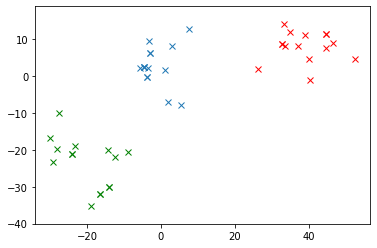

In [602]:
plt.plot(x1, y1, 'x')
plt.plot(x2, y2, 'x', color='g')
plt.plot(x3, y3, 'x', color='r')
plt.axis('equal')
plt.show();

In [686]:
# https://en.wikipedia.org/wiki/EM_algorithm_and_GMM_model
# K = 3, i (num_m) = 15
def E_step(x, phis, means, covs):
    # w = shape([phi, x]) (3,45)
    w = np.zeros([phis.shape[0], x.shape[0]])
    # phi = the probability for one model
    # multivariate_normal
    for i, xi in enumerate(x):
        below = 0
        for alpha, mean, cov in zip(phis, means, covs):
            this_gaussian = multivariate_normal(mean=mean, cov=cov)
            below += alpha * this_gaussian.pdf(xi)
        
        # print("below: ", below)
        for j, alpha in enumerate(phis):
            this_gaussian = multivariate_normal(mean=means[j], cov=covs[j])
            above = alpha * this_gaussian.pdf(xi)
            # print(above)
            w[j, i] = above / below
    return w

def M_step(x, means, w):
    # w = shape([phi, x]) (3,45)
    # x = array([x1,x2,...,xn]) (45,2)
    # means = shape([phi])
    
    w_each_sum = np.zeros((w.shape[0]))
    for j in range(w.shape[0]):
        w_each_sum[j] = w[j, :].sum()
    
    phis = w_each_sum / x.shape[0]
    
    mus = np.zeros((w.shape[0],x.shape[1]))
    for j in range(w.shape[0]):
        for i in range(x.shape[0]):
            mus[j] += w[j, i] * x[i]
        mus[j] = mus[j] / w_each_sum[j]
    
    sigma = np.zeros((w.shape[0],x.shape[1],x.shape[1]))
    for j in range(w.shape[0]):
        for i in range(x.shape[0]):
            expand_matrix = np.repeat((x[i] - mus[j])[:,None], x.shape[1], 1)
            # sigma[j] += w[j, i] * expand_matrix @ expand_matrix.T
            sigma[j] += w[j, i] * (expand_matrix * expand_matrix.T)
        sigma[j] = sigma[j] / w_each_sum[j]
    return phis, mus, sigma

def log_likelihood(w, x, phis, means, covs):
    # w = (phi, x)
    value = 0.0
    for i in range(x.shape[0]): # 45
        tmp_value = 0.0
        for j in range(w.shape[0]): # 3
            this_gaussian = multivariate_normal(mean=means[j], cov=covs[j])
            tmp_value += phis[j] * this_gaussian.pdf(x[i])
        value += np.log(tmp_value)
#     for j in range(w.shape[0]): # 3
#         tmp_value = 0.0
#         for i in range(x.shape[0]): # 45
#             tmp_value += w[j,i]
#         value += np.log(tmp_value)
    return value / x.shape[0]

In [603]:
X = np.concatenate([[x1,y1],[x2,y2],[x3,y3]], axis=1).T

In [604]:
X.shape

(45, 2)

In [641]:
# mean_1, cov_1 = [0,0], [[20, 0], [0, 50]]
# mean_2, cov_2 = [-20, -20], [[40, 0], [0, 40]]
# mean_3, cov_3 = [40, 10], [[30, 0], [0, 20]]
init_phi = [0.5,0.2,0.3]
init_means = [[10,10],[-10,-10],[10,-10]]
init_covs = [[[2,0],[0,2]],[[3,0],[0,3]],[[5,0],[0,5]]]
init_phi = np.array(init_phi)
init_means = np.array(init_means)
init_covs = np.array(init_covs)

In [666]:
# weight_phis = init_phi
# weight_means = init_means
# weight_covs = init_covs

weight_phis = np.array([0.33,0.33,0.33])
weight_means = np.array([mean_1,mean_2,mean_3])
weight_covs = np.array([cov_1,cov_2,cov_3])
iteration = 10
range_factor = int(iteration / 10)
last_val_log_likelihood = 0
ori_w = E_step(X, np.array([0.33,0.33,0.33]), np.array([mean_1,mean_2,mean_3]), np.array([cov_1,cov_2,cov_3]))
ori_log_likelihood = log_likelihood(ori_w, X, np.array([0.33,0.33,0.33]), np.array([mean_1,mean_2,mean_3]), np.array([cov_1,cov_2,cov_3]))
print("ori_log_likelihood: ", ori_log_likelihood)
for idx in range(iteration):
    w = E_step(X, weight_phis, weight_means, weight_covs)
    last_val_log_likelihood = log_likelihood(w, X, weight_phis, weight_means, weight_covs)
    weight_phis, weight_means, weight_covs = M_step(X, weight_means, w)
    curr_val_log_likelihood = log_likelihood(w, X, weight_phis, weight_means, weight_covs)
    
    if (idx+1) % range_factor == 0:
    # if True:
        print("-" * 5 + "step: " + str(idx+1) + "-" * 5)
        print("log-likelihood loss (E-step): ", last_val_log_likelihood)
        print("log-likelihood loss (M-step): ", curr_val_log_likelihood)
        print("phis:  ", weight_phis)
        print("means: ", weight_means)
        print("covs:  ", weight_covs)

ori_log_likelihood:  -7.490619460409706
-----step: 1-----
log-likelihood loss (E-step):  -7.490619460409706
log-likelihood loss (M-step):  -7.442944185852735
phis:   [0.33355779 0.33310894 0.33333327]
means:  [[ -1.4509564    2.60419974]
 [-20.15483156 -23.57944306]
 [ 38.87756392   7.92852531]]
covs:   [[[ 31.79764459   0.76870396]
  [  0.76870396  56.49502063]]

 [[ 87.64518864 -43.13011912]
  [-43.13011912  88.65822936]]

 [[ 87.62208115  -0.38803715]
  [ -0.38803715  30.09606185]]]
-----step: 2-----
log-likelihood loss (E-step):  -7.442944185852735
log-likelihood loss (M-step):  -7.446126410341055
phis:   [0.33350236 0.33273    0.33376764]
means:  [[ -1.47173077   2.56697198]
 [-20.16657957 -23.58431638]
 [ 38.83631437   7.9339252 ]]
covs:   [[[ 31.77937568   0.98174997]
  [  0.98174997  57.41658087]]

 [[ 87.48578961 -43.29708362]
  [-43.29708362  88.64667744]]

 [[ 90.12457622  -0.72218319]
  [ -0.72218319  30.11388048]]]
-----step: 3-----
log-likelihood loss (E-step):  -7.446126

ell_radius_x:  0.712668595912205
ell_radius_y:  1.221516873563573
scale_x:  28.05315010745799
scale_y:  28.248642941374108
mean_x:  -20.16974510059695
mean_y:  -23.585221278205413


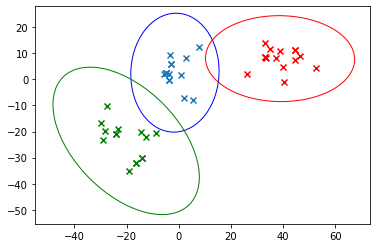

In [667]:
fig, axs = plt.subplots()
draw_ellipse(weight_means[0], weight_covs[0], axs, edgecolor='blue')
draw_ellipse(weight_means[1], weight_covs[1], axs, ifprint=True, edgecolor='green')
draw_ellipse(weight_means[2], weight_covs[2], axs, edgecolor='red')
axs.scatter(x1, y1, marker='x')
axs.scatter(x2, y2, marker='x', color='g')
axs.scatter(x3, y3, marker='x', color='r')
axs.axis('equal')
plt.show()

## only 1 model

In [683]:
weight_phis = np.array([1])
weight_means = np.array([mean_1])
weight_covs = np.array([cov_1])
true_X = model1.rvs(size=100)
iteration = 10
range_factor = int(iteration / 10)
last_val_log_likelihood = 0
ori_w = E_step(true_X, np.array([1.0]), np.array([mean_1]), np.array([cov_1]))
ori_log_likelihood = log_likelihood(ori_w, true_X, np.array([1]), np.array([mean_1]), np.array([cov_1]))
print("ori_log_likelihood: ", ori_log_likelihood)
for idx in range(iteration):
    w = E_step(true_X, weight_phis, weight_means, weight_covs)
    last_val_log_likelihood = log_likelihood(w, true_X, weight_phis, weight_means, weight_covs)
    weight_phis, weight_means, weight_covs = M_step(true_X, weight_means, w)
    curr_val_log_likelihood = log_likelihood(w, true_X, weight_phis, weight_means, weight_covs)
    
    if (idx+1) % range_factor == 0:
    # if True:
        print("-" * 5 + "step: " + str(idx+1) + "-" * 5)
        print("log-likelihood loss (E-step): ", last_val_log_likelihood)
        print("log-likelihood loss (M-step): ", curr_val_log_likelihood)
        print("phis:  ", weight_phis)
        print("means: ", weight_means)
        print("covs:  ", weight_covs)

ori_log_likelihood:  -6.3491040291015315
-----step: 1-----
log-likelihood loss (E-step):  -6.3491040291015315
log-likelihood loss (M-step):  -6.536698499581956
phis:   [1.]
means:  [[ 0.2221058  -0.09713301]]
covs:   [[[44.66838672 -3.06568865]
  [-3.06568865 99.53337325]]]
-----step: 2-----
log-likelihood loss (E-step):  -6.536698499581956
log-likelihood loss (M-step):  -6.536698499581956
phis:   [1.]
means:  [[ 0.2221058  -0.09713301]]
covs:   [[[44.66838672 -3.06568865]
  [-3.06568865 99.53337325]]]
-----step: 3-----
log-likelihood loss (E-step):  -6.536698499581956
log-likelihood loss (M-step):  -6.536698499581956
phis:   [1.]
means:  [[ 0.2221058  -0.09713301]]
covs:   [[[44.66838672 -3.06568865]
  [-3.06568865 99.53337325]]]
-----step: 4-----
log-likelihood loss (E-step):  -6.536698499581956
log-likelihood loss (M-step):  -6.536698499581956
phis:   [1.]
means:  [[ 0.2221058  -0.09713301]]
covs:   [[[44.66838672 -3.06568865]
  [-3.06568865 99.53337325]]]
-----step: 5-----
log-like

[[44.66838672 -3.06568865]
 [-3.06568865 99.53337325]]
[ 0.2221058  -0.09713301]
ell_radius_x:  0.9767408514057839
ell_radius_y:  1.0227303208544785
scale_x:  20.05032370086113
scale_y:  29.929924144154647
mean_x:  0.22210580193303542
mean_y:  -0.09713300947296874
[[20, 0], [0, 50]]
[0, 0]
ell_radius_x:  1.0
ell_radius_y:  1.0
scale_x:  13.416407864998739
scale_y:  21.213203435596427
mean_x:  0
mean_y:  0


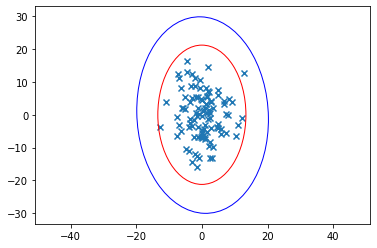

In [684]:
fig, axs = plt.subplots()
print(weight_covs[0])
print(weight_means[0])
draw_ellipse(weight_means[0], weight_covs[0], axs, edgecolor='blue', ifprint=True)
print(cov_1)
print(mean_1)

draw_ellipse(np.array(mean_1), np.array(cov_1), axs, edgecolor='red', ifprint=True)
axs.scatter(true_X[:,0], true_X[:,1], marker='x')
axs.axis('equal')
plt.show()

In [ ]:
# mean_1, cov_1 = [0,0], [[20, 0], [0, 50]]
# mean_2, cov_2 = [-20, -20], [[40, 0], [0, 40]]
# mean_3, cov_3 = [40, 10], [[30, 0], [0, 20]]
# test_phi = [0.33,0.33,0.34]
# test_means = [[10,10],[-10,10],[-10,10]]
# test_covs = [[[10,0],[0,10]],[[10,0],[0,5]],[[5,0],[0,5]]]

In [650]:
predict_models = [multivariate_normal(mean=mean, cov=cov) for mean, cov in zip(weight_means, weight_covs)]

ell_radius_x:  1.091939931215826
ell_radius_y:  0.8987030580878077
scale_x:  39.311575584152926
scale_y:  35.027825688299714
mean_x:  -17.944052008425416
mean_y:  -21.882177651775677


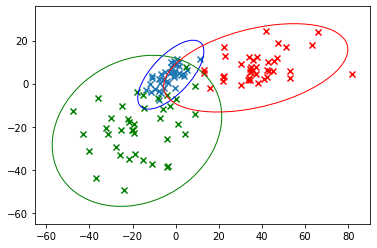

In [652]:
fig, axs = plt.subplots()
draw_ellipse(weight_means[0], weight_covs[0], axs, edgecolor='blue')
draw_ellipse(weight_means[1], weight_covs[1], axs, ifprint=True, edgecolor='green')
draw_ellipse(weight_means[2], weight_covs[2], axs, edgecolor='red')

pX1, pY1 = predict_models[0].rvs(size=40).T
pX2, pY2 = predict_models[1].rvs(size=40).T
pX3, pY3 = predict_models[2].rvs(size=40).T

axs.scatter(pX1, pY1, marker='x')
axs.scatter(pX2, pY2, marker='x', color='g')
axs.scatter(pX3, pY3, marker='x', color='r')
axs.axis('equal')
plt.show()

In [338]:
w = E_step(X, test_phi, test_means, test_covs)
M_step(X, test_means, w)

w shape: (3, 45)


(array([0.14051132, 0.18685987, 0.00270847]),
 (array([ 33.37330096, -13.31298161,  -3.61616836]),
  array([  6.74543084, -11.6670115 ,   7.18428877])),
 (array([299.079848  , 110.0958214 ,   2.93929013]),
  array([88.14729402, 82.3191939 ,  4.41608417])))

In [339]:
test_mean_x = np.array([ 33.37330096, -13.31298161,  -3.61616836])
test_mean_y = np.array([  6.74543084, -11.6670115 ,   7.18428877])

In [349]:
test_mean_set = np.array([test_mean_x, test_mean_y]).T

In [354]:
test_mean_set

array([[ 33.37330096,   6.74543084],
       [-13.31298161, -11.6670115 ],
       [ -3.61616836,   7.18428877]])

In [358]:
test_covs.shape

(3, 2, 2)

In [359]:
np.array([np.diag(x) for x in test_mean_set])

array([[[ 33.37330096,   0.        ],
        [  0.        ,   6.74543084]],

       [[-13.31298161,   0.        ],
        [  0.        , -11.6670115 ]],

       [[ -3.61616836,   0.        ],
        [  0.        ,   7.18428877]]])

In [160]:
test = np.reshape(np.arange(18), (3,6))

In [194]:
print(test.shape)
print(test[:, None, :].shape)

(3, 6)
(3, 1, 6)


In [153]:
test_x = np.arange(6)
test_x

array([0, 1, 2, 3, 4, 5])

In [167]:
test @ test_x.T

array([ 55, 145, 235])

In [156]:
test_mu = np.reshape(np.arange(18), (3,6))
test_mu

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17]])

In [168]:
(test * (test_x - test_mu) @ (test_x - test_mu).T).sum(axis=1) / (test @ test_x.T)

array([ 0.        , 37.9862069 , 79.96595745])

In [127]:
model1.pdf(0.02786108)

0.005032784475928499

In [122]:
x1

array([ 0.02786108, -1.4353515 , -4.70420441, -3.64451876, -0.56773295,
       -4.1035731 ,  4.23150966, -1.00967576,  4.23150966, -3.24111043,
       -0.56773295, -5.86225546, -3.58489028, -4.77814217,  4.8688722 ])

In [123]:
y1

array([ 10.93663758,  -5.78447772,   2.25678844,   2.10794496,
        11.62282714,  -0.22276487,  -7.3476787 ,   7.77628081,
        -7.3476787 ,   9.37550594,  11.62282714,   3.52181097,
       -10.52524645,  -5.95747632, -15.5803036 ])